# Approach 0 : Basic search, in-memory embedding storage and retrieval (Deafult opt)

In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

claim = 'India became a republic in 1947.'
context = 'India gained independence from British rule in 1947, but it became a republic on January 26, 1950, when the Constitution of India came into effect.'

input_schema = {
    'claim' : claim,
    'context' : context
}

# Generate the search query
# search_query = generate_search_query(input_schema)
search_query = input_schema['claim']
print(search_query)

from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack import Pipeline
from haystack import Document
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import MultiFileConverter
# DocumentPreprocessor : Splitter + Cleaner
from haystack.components.preprocessors import DocumentPreprocessor

from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter



# Other than Haystack imports
from typing import List
from print.with_color import print_wc

document_store = InMemoryDocumentStore()
model = "sentence-transformers/all-MiniLM-L6-v2"

web_search = DuckduckgoApiWebSearch(top_k=3, backend= 'auto')
link_fetcher = LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2)
file_converter = MultiFileConverter()
doc_embedder = SentenceTransformersDocumentEmbedder(model=model)
doc_writer = DocumentWriter(document_store=document_store)


indexing_pipeline = Pipeline()
indexing_pipeline.add_component("search", web_search)
indexing_pipeline.add_component("fetcher", link_fetcher)
indexing_pipeline.add_component("converter", file_converter)
indexing_pipeline.add_component("embedder", doc_embedder)
indexing_pipeline.add_component("writer", doc_writer)

indexing_pipeline.warm_up()

indexing_pipeline.connect('search.links', 'fetcher.urls')
indexing_pipeline.connect('fetcher.streams', 'converter.sources')
indexing_pipeline.connect('converter.documents', 'embedder.documents')
indexing_pipeline.connect('embedder.documents', 'writer.documents')


from haystack_integrations.components.generators.ollama import OllamaChatGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage


doc_store_retriever = InMemoryEmbeddingRetriever(document_store)
retreieval_query_embedder = SentenceTransformersTextEmbedder(model=model)

chat_ollama = OllamaChatGenerator(model="mistral:latest",
                            url = "http://localhost:11434",
                            )


template = [
    ChatMessage.from_user(
        """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""
    )
]

prompt_builder = ChatPromptBuilder(template=template)

retrieval_pipeline = Pipeline()

retrieval_pipeline.add_component("retreieval_query_embedder", retreieval_query_embedder)
retrieval_pipeline.add_component("doc_store_retriever", doc_store_retriever)
retrieval_pipeline.add_component("prompt_builder", prompt_builder)
retrieval_pipeline.add_component("chat_generator", chat_ollama)

retrieval_pipeline.warm_up()

retrieval_pipeline.connect('retreieval_query_embedder.embedding','doc_store_retriever.query_embedding')
retrieval_pipeline.connect('doc_store_retriever','prompt_builder')
retrieval_pipeline.connect('prompt_builder.prompt', 'chat_generator.messages')


doc_retrieval_query_str = str(f"{claim} — based on: {context}")
answer_format = ("{true/false}.{evidence1}.{evidence2}")
augmentor_query_str = str(f"Is the aforementioned fact,'{claim}', true or false in the context, '{context}' ? Also, quote sentences which verify your answer. Respond strictly in format: {answer_format}")


response = retrieval_pipeline.run({"retreieval_query_embedder": {"text": doc_retrieval_query_str}, "prompt_builder": {"question": augmentor_query_str}})
print_wc(response)

print('-'*105)

result = response['chat_generator']['replies'][0].text
print_wc(str(result))

# Approach 1 : RAG + ExtractAnswer output

In [6]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

claim = 'India became a republic in 1947.'
context = 'India gained independence from British rule in 1947, but it became a republic on January 26, 1950, when the Constitution of India came into effect.'

input_schema = {
    'claim' : claim,
    'context' : context
}

# Generate the search query
# search_query = generate_search_query(input_schema)
search_query = input_schema['claim']
print(search_query)

from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack import Pipeline
from haystack import Document
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import MultiFileConverter
# DocumentPreprocessor : Splitter + Cleaner
from haystack.components.preprocessors import DocumentPreprocessor

from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter



# Other than Haystack imports
from typing import List
from print.with_color import print_wc

document_store = InMemoryDocumentStore()
model = "sentence-transformers/all-MiniLM-L6-v2"

web_search = DuckduckgoApiWebSearch(top_k=3, backend= 'auto')
link_fetcher = LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2)
file_converter = MultiFileConverter()
doc_embedder = SentenceTransformersDocumentEmbedder(model=model)
doc_writer = DocumentWriter(document_store=document_store)


indexing_pipeline = Pipeline()
indexing_pipeline.add_component("search", web_search)
indexing_pipeline.add_component("fetcher", link_fetcher)
indexing_pipeline.add_component("converter", file_converter)
indexing_pipeline.add_component("embedder", doc_embedder)
indexing_pipeline.add_component("writer", doc_writer)

indexing_pipeline.warm_up()

indexing_pipeline.connect('search.links', 'fetcher.urls')
indexing_pipeline.connect('fetcher.streams', 'converter.sources')
indexing_pipeline.connect('converter.documents', 'embedder.documents')
indexing_pipeline.connect('embedder.documents', 'writer.documents')

indexing_pipeline.run({"search": {'query' : search_query}})


from haystack_integrations.components.generators.ollama import OllamaChatGenerator

from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage


doc_store_retriever = InMemoryEmbeddingRetriever(document_store)
retrieved_doc_reader = ExtractiveReader()
retreieval_query_embedder = SentenceTransformersTextEmbedder(model=model)

chat_ollama = OllamaChatGenerator(model="mistral:latest",
                            url = "http://localhost:11434",
                            )


template = [
    ChatMessage.from_user(
        """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""
    )
]

prompt_builder = ChatPromptBuilder(template=template)

retrieval_pipeline = Pipeline()

retrieval_pipeline.add_component("retreieval_query_embedder", retreieval_query_embedder)
retrieval_pipeline.add_component("doc_store_retriever", doc_store_retriever)
retrieval_pipeline.add_component("retrieved_doc_reader", retrieved_doc_reader)
# retrieval_pipeline.add_component("prompt_builder", prompt_builder)
# retrieval_pipeline.add_component("chat_generator", chat_ollama)

retrieval_pipeline.warm_up()

retrieval_pipeline.connect('retreieval_query_embedder.embedding','doc_store_retriever.query_embedding')
retrieval_pipeline.connect('doc_store_retriever','retrieved_doc_reader')
# retrieval_pipeline.connect('doc_store_retriever','prompt_builder')
# retrieval_pipeline.connect('prompt_builder.prompt', 'chat_generator.messages')


doc_retrieval_query_str = str(f"{claim} — based on: {context}")
answer_format = ("{true/false}.{evidence1}.{evidence2}")
augmentor_query_str = str(f"Is the aforementioned fact,'{claim}', true or false in the context, '{context}' ? Also, quote sentences which verify your answer. Respond strictly in format: {answer_format}")


# response = retrieval_pipeline.run({"retreieval_query_embedder": {"text": doc_retrieval_query_str}, "prompt_builder": {"question": augmentor_query_str}})
response = retrieval_pipeline.run({"retreieval_query_embedder": {"text": doc_retrieval_query_str}, "retrieved_doc_reader": {'query': augmentor_query_str}})
# print_wc(response)

print('-'*105)

# result = response['chat_generator']['replies'][0].text
# print_wc(str(result))

India became a republic in 1947.


DEBUG - haystack.core.pipeline.base -  Adding component 'router' (<haystack.components.routers.file_type_router.FileTypeRouter object at 0x000001D705E52C40>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
Outputs:
  - unclassified: List[Union[str, Path, ByteStream]]
  - text/csv: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.wordprocessingml.document: List[Union[str, Path, ByteStream]]
  - text/html: List[Union[str, Path, ByteStream]]
  - application/json: List[Union[str, Path, ByteStream]]
  - text/markdown: List[Union[str, Path, ByteStream]]
  - text/plain: List[Union[str, Path, ByteStream]]
  - application/pdf: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.presentationml.presentation: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.spreadsheetml.sheet: List[Union[str, Path, ByteStream]])
DEBUG - haystack.cor

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - haystack.core.pipeline.pipeline -  Running component writer
WARNING - haystack.components.builders.chat_prompt_builder -  ChatPromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
DEBUG - haystack.core.pipeline.base -  Adding component 'retreieval_query_embedder' (<haystack.components.embedders.sentence_transformers_text_embedder.SentenceTransformersTextEmbedder object at 0x000001D70913A9E0>

Inputs:
  - text: str
Outputs:
  - embedding: List[float])
DEBUG - haystack.core.pipeline.base -  Adding component 'doc_store_retriever' (<haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever object at 0x000001D70913A3F0>

Inputs:
  - query_embedding: List[float]
  - filters: Optional[Dict[str, A

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - haystack.core.pipeline.pipeline -  Running component doc_store_retriever
INFO - haystack.core.pipeline.pipeline -  Running component retrieved_doc_reader


---------------------------------------------------------------------------------------------------------


# Conclusion of Approach 1 :
1. performs worse than expected.

In [42]:
from question_maker import to_question

# Approach 2.1.Only using ExtractedAnswer
1. using 'claim' for both 'search' and 'extractor' as their 'query' inputs.

India became a republic in 1947.


DEBUG - haystack.core.pipeline.base -  Adding component 'router' (<haystack.components.routers.file_type_router.FileTypeRouter object at 0x000001D709C34230>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
Outputs:
  - unclassified: List[Union[str, Path, ByteStream]]
  - text/csv: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.wordprocessingml.document: List[Union[str, Path, ByteStream]]
  - text/html: List[Union[str, Path, ByteStream]]
  - application/json: List[Union[str, Path, ByteStream]]
  - text/markdown: List[Union[str, Path, ByteStream]]
  - text/plain: List[Union[str, Path, ByteStream]]
  - application/pdf: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.presentationml.presentation: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.spreadsheetml.sheet: List[Union[str, Path, ByteStream]])
DEBUG - haystack.cor

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

c:\02_AIML_Projects\Haystack\.haystack\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\priya\.cache\huggingface\hub\models--deepset--roberta-large-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

DEBUG - haystack.core.pipeline.draw -  Mermaid diagram:

%%{ init: {"theme": "neutral"} }%%

graph TD;

i{&ast;}--"query<br><small><i>str</i></small>"--> search["<b>search</b><br><small><i>DuckduckgoApiWebSearch</i></small>"]:::component
i{&ast;}--"urls<br><small><i>List[str]</i></small>"--> fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component
i{&ast;}--"sources<br><small><i>List[Union[str, Path, ByteStream]]</i></small>"--> converter["<b>converter</b><br><small><i>MultiFileConverter<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li></ul></i></small>"]:::component
i{&ast;}--"documents<br><small><i>List[Document]</i></small>"--> preprocessor["<b>preprocessor</b><br><small><i>DocumentPreprocessor</i></small>"]:::component
i{&ast;}--"query<br><small><i>str</i></small>"--> extractor["<b>extractor</b><br><small><i>ExtractiveReader<br><br>Optional inputs:<ul style='text-align:left;'><li>top_k (Optional[

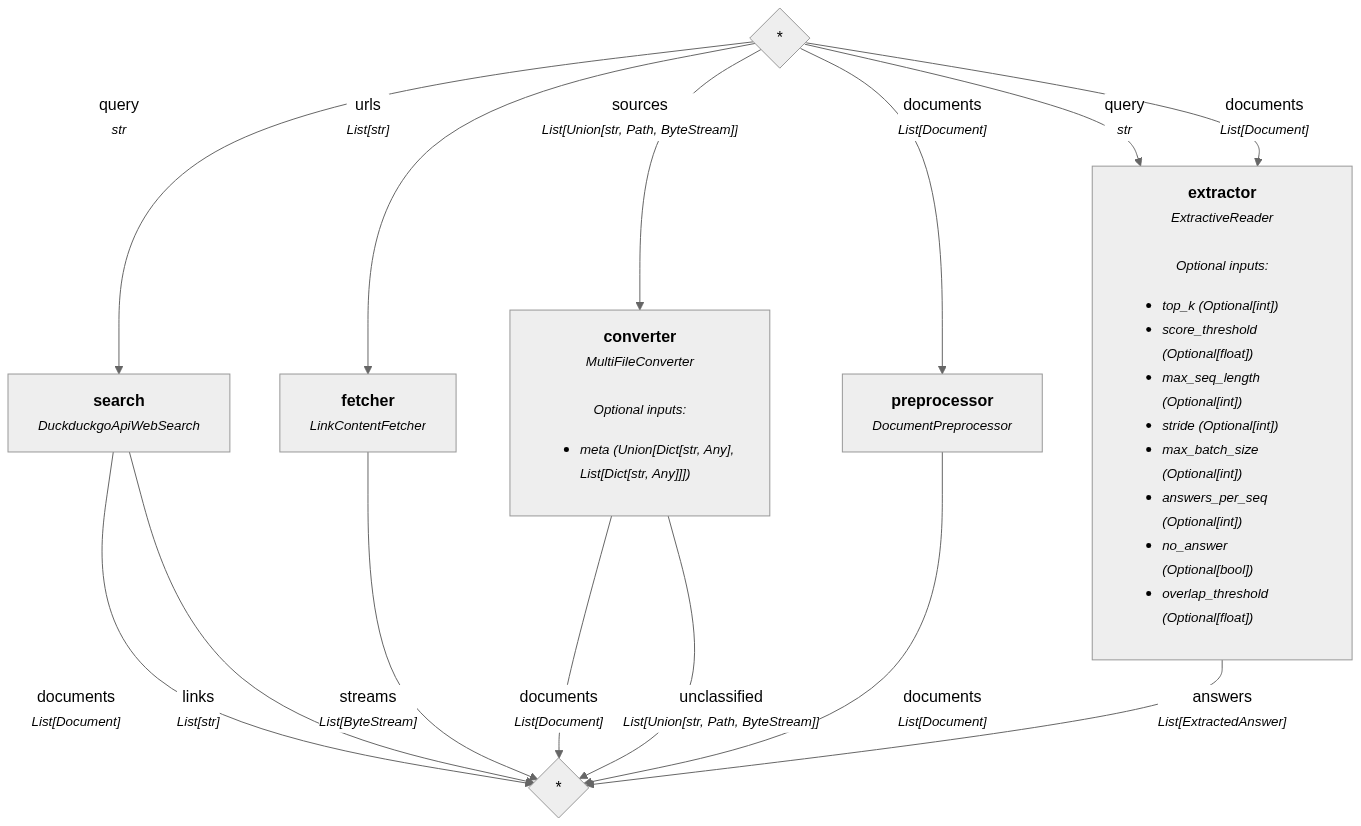

DEBUG - haystack.core.pipeline.base -  Connecting 'search.links' to 'fetcher.urls'
DEBUG - haystack.core.pipeline.base -  Connecting 'fetcher.streams' to 'converter.sources'
DEBUG - haystack.core.pipeline.base -  Connecting 'converter.documents' to 'preprocessor.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'preprocessor.documents' to 'extractor.documents'
DEBUG - haystack.core.pipeline.draw -  Mermaid diagram:

%%{ init: {"theme": "neutral"} }%%

graph TD;

search["<b>search</b><br><small><i>DuckduckgoApiWebSearch</i></small>"]:::component -- "links -> urls<br><small><i>List[str]</i></small>" --> fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component
fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component -- "streams -> sources<br><small><i>List[ByteStream]</i></small>" --> converter["<b>converter</b><br><small><i>MultiFileConverter<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], Li

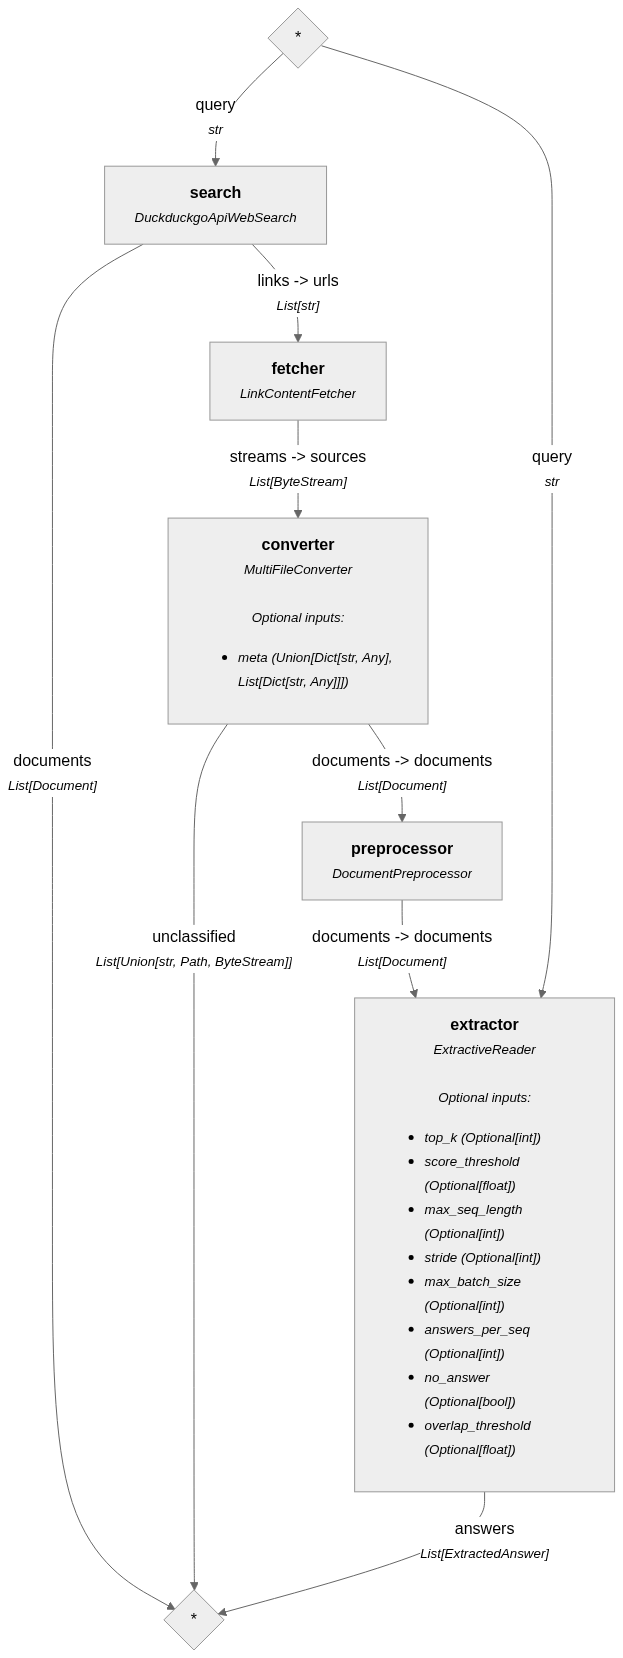

INFO - haystack.core.pipeline.base -  Warming up component converter...
INFO - haystack.core.pipeline.base -  Warming up component preprocessor...
INFO - haystack.core.pipeline.base -  Warming up component extractor...
INFO - haystack.core.pipeline.pipeline -  Running component search
INFO - haystack.core.pipeline.pipeline -  Running component fetcher
INFO - haystack.core.pipeline.pipeline -  Running component converter
INFO - haystack.core.pipeline.pipeline -  Running component router
INFO - haystack.core.pipeline.pipeline -  Running component html
WARNING - trafilatura.xml -  missing link attribute: Mountbatten {}'
WARNING - trafilatura.xml -  missing link attribute: [33] {}'
WARNING - trafilatura.xml -  missing link attribute: governor-general {}'
WARNING - trafilatura.xml -  missing link attribute: [34] {}'
WARNING - trafilatura.xml -  missing link attribute: [38] {}'
WARNING - trafilatura.xml -  missing link attribute: [39] {}'
WARNING - trafilatura.xml -  missing link attribute: 

ExtractedAnswer(
    query='Do india became a republic in 1947?',
    score=0.5644647479057312,
    data='India was declared a free country in 1947, it is important to understand that it did not attain complete freedom. She 
was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor General, and had no democracy or 
constitution in place. India’s citizens were denied the freedom of electing their own leaders – who could run the country. It was 
only after the Constitution of India came into effect on 26th January 1950',
    document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke of the midnight
hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'content_type': 'text/html', 'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}),
    context=None,
    document_offset=Span(
        start=342,
        end=793
    ),
    context_offset=None,
    meta={
        'answer_page_number': 1
    }
)

ExtractedAnswer(
    query='Do india became a republic in 1947?',
    score=0.5644647479057312,
    data='India was declared a free country in 1947, it is important to understand that it did not attain complete 
freedom. She was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor 
General, and had no democracy or constitution in place. India’s citizens were denied the freedom of electing their 
own leaders – who could run the country. It was only after the Constitution of India came into effect on 26th 
January 1950',
    document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke 
of the midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'content_type': 
'text/html', 'url': 'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 
'split_idx_start': 0}),
    context=None,
    document_offset=Span(
        start=342,
        end=793
    ),
    context_offset=None,
    meta={
        'answer_page_number': 1
    }
)

'At the stroke of the midnight hour on August 15, 1947, when the world slept, India woke to life and freedom. ## But have you ever
wondered: If India successfully overthrew the British Raj on 15th August 1947, why did it wait for over two and a half years to 
become a Republic? The history behind this is particularly interesting. Even though India was declared a free country in 1947, it 
is important to understand that it did not attain complete freedom. She was still a constitutional monarchy under King George VI, 
with Earl Mountbatten as the Governor General, and had no democracy or constitution in place. India’s citizens were denied the 
freedom of electing their own leaders – who could run the country. It was only after the Constitution of India came into effect on
26th January 1950, replacing the Government of India Act (1935) as the governing document of India, did our nation truly became a 
Republic. So how did that happen? To start with, under the leadership of Dr Babasaheb Ambedkar as the chairman, the Drafting 
Committee for a permanent constitution was appointed. ## This committee worked vigorously and its final version was ratified by 
the Constituent Assembly on 26 November, 1949. But the Assembly still waited till 26 January, 1950 to formally promulgate it. This
was to commemorate that day in 1930, when the Indian National Congress first made the ‘Declaration of Total Indian Independence’, 
or Poorna Swaraj from the British Raj. At the start of the freedom struggle, most political parties in India were'

'At the stroke of the midnight hour on August 15, 1947, when the world slept, India woke to life and freedom. ## 
But have you ever wondered: If India successfully overthrew the British Raj on 15th August 1947, why did it wait 
for over two and a half years to become a Republic? The history behind this is particularly interesting. Even 
though India was declared a free country in 1947, it is important to understand that it did not attain complete 
freedom. She was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor 
General, and had no democracy or constitution in place. India’s citizens were denied the freedom of electing their 
own leaders – who could run the country. It was only after the Constitution of India came into effect on 26th 
January 1950, replacing the Government of India Act (1935) as the governing document of India, did our nation truly
became a Republic. So how did that happen? To start with, under the leadership of Dr Babasaheb Ambedkar as the 
chairman, the Drafting Committee for a permanent constitution was appointed. ## This committee worked vigorously 
and its final version was ratified by the Constituent Assembly on 26 November, 1949. But the Assembly still waited 
till 26 January, 1950 to formally promulgate it. This was to commemorate that day in 1930, when the Indian National
Congress first made the ‘Declaration of Total Indian Independence’, or Poorna Swaraj from the British Raj. At the 
start of the freedom struggle, most political parties in India were'

259

259

In [41]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

claim = 'India became a republic in 1947.'
context = 'India gained independence from British rule in 1947, but it became a republic on January 26, 1950, when the Constitution of India came into effect.'

input_schema = {
    'claim' : claim,
    'context' : context
}

# Generate the search query
# search_query = generate_search_query(input_schema)
search_query = input_schema['claim']
print(search_query)

from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack import Pipeline
from haystack import Document
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import MultiFileConverter
from haystack.components.preprocessors import DocumentPreprocessor
from haystack.components.readers import ExtractiveReader

# Other than Haystack imports
from typing import List
from print.with_color import print_wc


web_search = DuckduckgoApiWebSearch(top_k=3, backend= 'auto')
link_fetcher = LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2)
file_converter = MultiFileConverter()
doc_preprocessor = DocumentPreprocessor()

ext_model = "deepset/roberta-large-squad2"
doc_extractor = ExtractiveReader(model=ext_model)



ext_pipeline = Pipeline()
ext_pipeline.add_component("search", web_search)
ext_pipeline.add_component("fetcher", link_fetcher)
ext_pipeline.add_component("converter", file_converter)
ext_pipeline.add_component("preprocessor", doc_preprocessor)
ext_pipeline.add_component("extractor", doc_extractor)

ext_pipeline.warm_up()
ext_pipeline.show()

ext_pipeline.connect('search.links','fetcher.urls')
ext_pipeline.connect('fetcher.streams','converter.sources')
ext_pipeline.connect('converter.documents','preprocessor.documents')
ext_pipeline.connect('preprocessor.documents','extractor.documents')
ext_pipeline.show()

# extractor_query = str(f"Find supporting evidence for the claim: '{search_query}'")
extractor_query = to_question(search_query)

result = ext_pipeline.run({"search": {'query' : search_query}, "extractor": {'query': extractor_query}})

# print_wc(result['extractor']['answers'][1])
from counter import count_words
print_wc(result['extractor']['answers'][0])
print_wc(result['extractor']['answers'][0].document.content)
print_wc(count_words(result['extractor']['answers'][0].document.content))

# Concluding Approach 2.1. 
#### Takeaways:
1.Would be going with top 2 results and verify them on context. as prompts to chatgenerator.
2.Worked wonderfully and extracted text without any extractive and retrieval pipeline is superior.

# Approach 2.2.ExtractAnswer + Chatgen(with context input)
1. using 'claim' for both 'search' and 'extractor' as their 'query' inputs.
2. using 'context' to extract only those inputs which are actually relevant.

# Approach 3.1.Extractive Pipeline only (no ChatGenerators)

India became a republic in 1947.


DEBUG - haystack.core.pipeline.base -  Adding component 'router' (<haystack.components.routers.file_type_router.FileTypeRouter object at 0x000001D709C9D470>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
Outputs:
  - unclassified: List[Union[str, Path, ByteStream]]
  - text/csv: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.wordprocessingml.document: List[Union[str, Path, ByteStream]]
  - text/html: List[Union[str, Path, ByteStream]]
  - application/json: List[Union[str, Path, ByteStream]]
  - text/markdown: List[Union[str, Path, ByteStream]]
  - text/plain: List[Union[str, Path, ByteStream]]
  - application/pdf: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.presentationml.presentation: List[Union[str, Path, ByteStream]]
  - application/vnd.openxmlformats-officedocument.spreadsheetml.sheet: List[Union[str, Path, ByteStream]])
DEBUG - haystack.cor

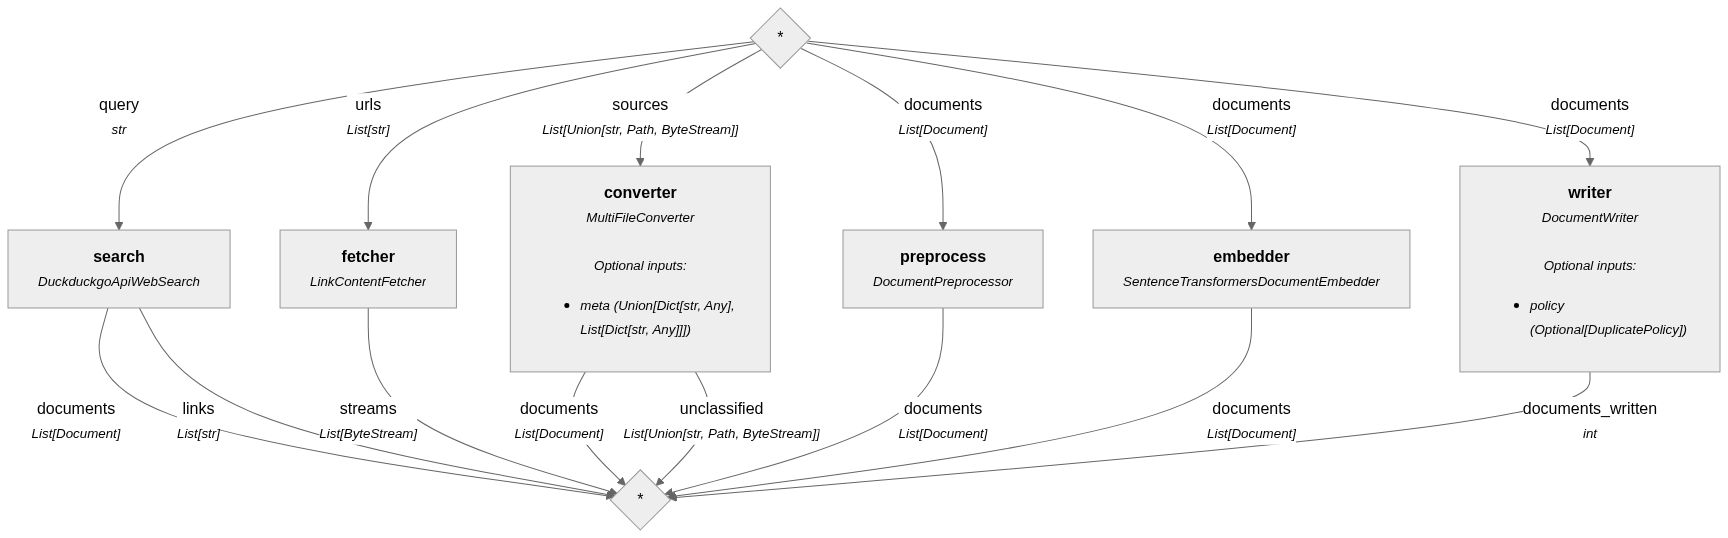

DEBUG - haystack.core.pipeline.base -  Connecting 'search.links' to 'fetcher.urls'
DEBUG - haystack.core.pipeline.base -  Connecting 'fetcher.streams' to 'converter.sources'
DEBUG - haystack.core.pipeline.base -  Connecting 'converter.documents' to 'preprocess.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'preprocess.documents' to 'embedder.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'embedder.documents' to 'writer.documents'
INFO - haystack.core.pipeline.base -  Warming up component converter...
INFO - haystack.core.pipeline.base -  Warming up component preprocess...
INFO - haystack.core.pipeline.base -  Warming up component splitter...
INFO - haystack.core.pipeline.base -  Warming up component embedder...
INFO - haystack.core.pipeline.pipeline -  Running component search
INFO - haystack.core.pipeline.pipeline -  Running component fetcher
INFO - haystack.core.pipeline.pipeline -  Running component converter
INFO - haystack.core.pipeline.pipeline -  Runn

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

INFO - haystack.core.pipeline.pipeline -  Running component writer
DEBUG - haystack.core.pipeline.base -  Adding component 'embedder' (<haystack.components.embedders.sentence_transformers_text_embedder.SentenceTransformersTextEmbedder object at 0x000001D7097D8B90>

Inputs:
  - text: str
Outputs:
  - embedding: List[float])
DEBUG - haystack.core.pipeline.base -  Adding component 'retriever' (<haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever object at 0x000001D7097D8CB0>

Inputs:
  - query_embedding: List[float]
  - filters: Optional[Dict[str, Any]]
  - top_k: Optional[int]
  - scale_score: Optional[bool]
  - return_embedding: Optional[bool]
Outputs:
  - documents: List[Document])
DEBUG - haystack.core.pipeline.base -  Adding component 'reader' (<haystack.components.readers.extractive.ExtractiveReader object at 0x000001D7091F2120>

Inputs:
  - query: str
  - documents: List[Document]
  - top_k: Optional[int]
  - score_threshold: Optional[float]
  - 

Do india became a republic in 1947?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - haystack.core.pipeline.pipeline -  Running component retriever
INFO - haystack.core.pipeline.pipeline -  Running component reader


{
    'reader': {
        'answers': [
            ExtractedAnswer(
                query='Do india became a republic in 1947?',
                score=0.5644647479057312,
                data='India was declared a free country in 1947, it is important to understand that it did not attain complete 
freedom. She was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor General, and had no 
democracy or constitution in place. India’s citizens were denied the freedom of electing their own leaders – who could run the 
country. It was only after the Constitution of India came into effect on 26th January 1950',
                document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke of 
the midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score:
25.945973651245964),
                context=None,
                document_offset=Span(
                    start=342,
                    end=793
                ),
                context_offset=None,
                meta={
                    'answer_page_number': 1
                }
            ),
            ExtractedAnswer(
                query='Do india became a republic in 1947?',
                score=0.5441374778747559,
                data='why did it wait for over two and a half years',
                document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke of 
the midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score:
25.945973651245964),
                context=None,
                document_offset=Span(
                    start=209,
                    end=254
                ),
                context_offset=None,
                meta={
                    'answer_page_number': 1
                }
            ),
            ExtractedAnswer(
                query='Do india became a republic in 1947?',
                score=0.1985441984941474,
                data=None,
                document=None,
                context=None,
                document_offset=None,
                context_offset=None,
                meta={}
            )
        ]
    }
}

{
    'reader': {
        'answers': [
            ExtractedAnswer(
                query='Do india became a republic in 1947?',
                score=0.5644647479057312,
                data='India was declared a free country in 1947, it is important to understand that it did not 
attain complete freedom. She was still a constitutional monarchy under King George VI, with Earl Mountbatten as the
Governor General, and had no democracy or constitution in place. India’s citizens were denied the freedom of 
electing their own leaders – who could run the country. It was only after the Constitution of India came into 
effect on 26th January 1950',
                document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At
the stroke of the midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: 
{'url': 'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 
'split_idx_start': 0}, score: 25.945973651245964),
                context=None,
                document_offset=Span(
                    start=342,
                    end=793
                ),
                context_offset=None,
                meta={
                    'answer_page_number': 1
                }
            ),
            ExtractedAnswer(
                query='Do india became a republic in 1947?',
                score=0.5441374778747559,
                data='why did it wait for over two and a half years',
                document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At
the stroke of the midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: 
{'url': 'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 
'split_idx_start': 0}, score: 25.945973651245964),
                context=None,
                document_offset=Span(
                    start=209,
                    end=254
                ),
                context_offset=None,
                meta={
                    'answer_page_number': 1
                }
            ),
            ExtractedAnswer(
                query='Do india became a republic in 1947?',
                score=0.1985441984941474,
                data=None,
                document=None,
                context=None,
                document_offset=None,
                context_offset=None,
                meta={}
            )
        ]
    }
}

----------------------------------------------------------------------------------------------------


ExtractedAnswer(
    query='Do india became a republic in 1947?',
    score=0.5644647479057312,
    data='India was declared a free country in 1947, it is important to understand that it did not attain complete freedom. She 
was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor General, and had no democracy or 
constitution in place. India’s citizens were denied the freedom of electing their own leaders – who could run the country. It was 
only after the Constitution of India came into effect on 26th January 1950',
    document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke of the midnight
hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score:
25.945973651245964),
    context=None,
    document_offset=Span(
        start=342,
        end=793
    ),
    context_offset=None,
    meta={
        'answer_page_number': 1
    }
)

ExtractedAnswer(
    query='Do india became a republic in 1947?',
    score=0.5644647479057312,
    data='India was declared a free country in 1947, it is important to understand that it did not attain complete 
freedom. She was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor 
General, and had no democracy or constitution in place. India’s citizens were denied the freedom of electing their 
own leaders – who could run the country. It was only after the Constitution of India came into effect on 26th 
January 1950',
    document=Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke 
of the midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 
'split_idx_start': 0}, score: 25.945973651245964),
    context=None,
    document_offset=Span(
        start=342,
        end=793
    ),
    context_offset=None,
    meta={
        'answer_page_number': 1
    }
)

----------------------------------------------------------------------------------------------------


'India was declared a free country in 1947, it is important to understand that it did not attain complete freedom. She was still a
constitutional monarchy under King George VI, with Earl Mountbatten as the Governor General, and had no democracy or constitution 
in place. India’s citizens were denied the freedom of electing their own leaders – who could run the country. It was only after 
the Constitution of India came into effect on 26th January 1950'

'India was declared a free country in 1947, it is important to understand that it did not attain complete freedom. 
She was still a constitutional monarchy under King George VI, with Earl Mountbatten as the Governor General, and 
had no democracy or constitution in place. India’s citizens were denied the freedom of electing their own leaders –
who could run the country. It was only after the Constitution of India came into effect on 26th January 1950'

----------------------------------------------------------------------------------------------------


Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke of the midnight hour on 
August 15, 1947, when the world slept, India woke to life and ...', meta: {'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score:
25.945973651245964)

Document(id=7b9606af388f7ac8ac08c8fe94a173082b1ee55b536db1df9b3aa864bd01e088, content: 'At the stroke of the 
midnight hour on August 15, 1947, when the world slept, India woke to life and ...', meta: {'url': 
'https://thebetterindia.com/129195/republic-day-history/', 'source_id': 
'4f663faa741ae966f0675b48c28baa082e73a11b9d8ffe29f6414bc556e8446f', 'page_number': 1, 'split_id': 0, 
'split_idx_start': 0}, score: 25.945973651245964)

----------------------------------------------------------------------------------------------------


0.5644647479057312

0.5644647479057312

----------------------------------------------------------------------------------------------------


In [44]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

claim = 'India became a republic in 1947.'
context = 'India gained independence from British rule in 1947, but it became a republic on January 26, 1950, when the Constitution of India came into effect.'

input_schema = {
    'claim' : claim,
    'context' : context
}

# Generate the search query
# search_query = generate_search_query(input_schema)
search_query = input_schema['claim']
print(search_query)

from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack_integrations.components.generators.ollama import OllamaChatGenerator
from haystack import Pipeline
from haystack import Document
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import MultiFileConverter
# DocumentPreprocessor : Splitter + Cleaner
from haystack.components.preprocessors import DocumentPreprocessor

from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter



# Other than Haystack imports
from typing import List
from print.with_color import print_wc

document_store = InMemoryDocumentStore()
model = "sentence-transformers/multi-qa-mpnet-base-dot-v1"

web_search = DuckduckgoApiWebSearch(top_k=3, backend= 'auto')
link_fetcher = LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2)
file_converter = MultiFileConverter()
doc_preprocessor = DocumentPreprocessor()
doc_embedder = SentenceTransformersDocumentEmbedder(model=model)
doc_writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("search", web_search)
indexing_pipeline.add_component("fetcher", link_fetcher)
indexing_pipeline.add_component("converter", file_converter)
indexing_pipeline.add_component("preprocess", doc_preprocessor)
indexing_pipeline.add_component("embedder", doc_embedder)
indexing_pipeline.add_component("writer", doc_writer)

indexing_pipeline.show()

indexing_pipeline.connect('search.links', 'fetcher.urls')
indexing_pipeline.connect('fetcher.streams', 'converter.sources')
indexing_pipeline.connect('converter.documents', 'preprocess.documents')
indexing_pipeline.connect('preprocess.documents', 'embedder.documents')
indexing_pipeline.connect('embedder.documents', 'writer.documents')

indexing_pipeline.run( { 'search' : { "query" : search_query } } )

ollama = OllamaChatGenerator(model="mistral:latest",
                            url = "http://localhost:11434",
                            )

from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
ext_model = "deepset/roberta-large-squad2"
reader = ExtractiveReader(model=ext_model)
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")
# extractive_qa_pipeline.add_component(instance=ollama, name="llm")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")


retrieval_query = str(f"{to_question(claim)}")
print(retrieval_query)

result = extractive_qa_pipeline.run(
    data={"embedder": {"text": retrieval_query}, "retriever": {"top_k": 3}, "reader": {"query": retrieval_query, "top_k": 2}}
)

print_wc(result)


extracted_answer = result['reader']['answers'][0]
ext_data = result['reader']['answers'][0].data
ext_data_from_doc = result['reader']['answers'][0].document
ext_data_score = result['reader']['answers'][0].score

print("-" * 100)
print_wc(extracted_answer)
print("-" * 100)
print_wc(ext_data)
print("-" * 100)
print_wc(ext_data_from_doc)
print("-" * 100)
print_wc(ext_data_score)
print("-" * 100)

# Approach 3.2.Extractive Pipeline + Chatgenerator

DEBUG - haystack.core.component.component -  Registering <class 'duckduckgo_api_haystack.duckduckgoapi.DuckduckgoApiWebSearch'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'duckduckgo_api_haystack.duckduckgoapi.DuckduckgoApiWebSearch'>


India became a republic in 1947.


DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.fetchers.link_content.LinkContentFetcher'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'haystack.components.fetchers.link_content.LinkContentFetcher'>
DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.converters.csv.CSVToDocument'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'haystack.components.converters.csv.CSVToDocument'>
DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.converters.docx.DOCXToDocument'> as a component
DEBUG - haystack.core.component.component -  Registered Component <class 'haystack.components.converters.docx.DOCXToDocument'>
DEBUG - haystack.core.component.component -  Registering <class 'haystack.components.converters.html.HTMLToDocument'> as a component
DEBUG - haystack.core.component.component -  Registered Component <clas

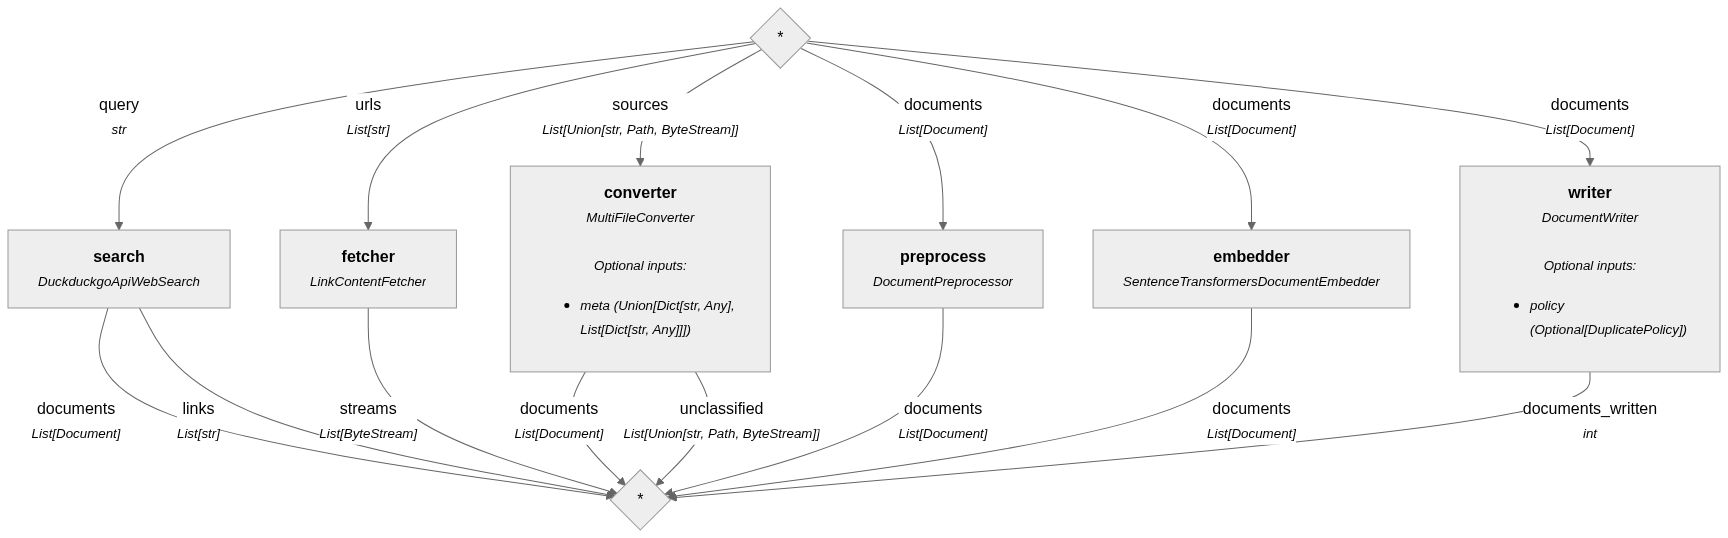

DEBUG - haystack.core.pipeline.base -  Connecting 'search.links' to 'fetcher.urls'
DEBUG - haystack.core.pipeline.base -  Connecting 'fetcher.streams' to 'converter.sources'
DEBUG - haystack.core.pipeline.base -  Connecting 'converter.documents' to 'preprocess.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'preprocess.documents' to 'embedder.documents'
DEBUG - haystack.core.pipeline.base -  Connecting 'embedder.documents' to 'writer.documents'
INFO - haystack.core.pipeline.base -  Warming up component converter...
INFO - haystack.core.pipeline.base -  Warming up component preprocess...
INFO - haystack.core.pipeline.base -  Warming up component splitter...
INFO - haystack.core.pipeline.base -  Warming up component embedder...
INFO - haystack.core.pipeline.pipeline -  Running component search
INFO - haystack.core.pipeline.pipeline -  Running component fetcher
INFO - haystack.core.pipeline.pipeline -  Running component converter
INFO - haystack.core.pipeline.pipeline -  Runn

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

INFO - haystack.core.pipeline.pipeline -  Running component writer


{'search': {'documents': [Document(id=2187be134b783f1f9ee99fda8a7c46dd7da9cd93470e059719dc24f63fa01237, content: 'Jawaharlal Nehru, the first prime minister of India, often regarded as the architect of modern India...', meta: {'title': 'History of India (1947-present) - Wikipedia', 'link': 'https://en.wikipedia.org/wiki/History_of_India_(1947–present)'}),
   Document(id=e573c3bcead20245a5be33c49618da86aaa02e15c5e9e9e347570fe8e1193469, content: 'A t the stroke of the midnight hour on August 15, 1947, when the world slept, India woke to life and...', meta: {'title': 'Why Did India Wait till 1950 to Become a Republic? - The Better India', 'link': 'https://thebetterindia.com/129195/republic-day-history/'}),
   Document(id=9a683f10923739301276697cd572ce2a4963a3f0040e5ab556b71c825116e849, content: 'Independence and Partition for India in 1947. India became an independent nation at midnight on Augu...', meta: {'title': 'INDEPENDENCE FOR INDIA IN 1947 - Facts and Details', 'link': 'https://fac

In [7]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

claim = 'India became a republic in 1947.'
context = 'India gained independence from British rule in 1947, but it became a republic on January 26, 1950, when the Constitution of India came into effect.'

input_schema = {
    'claim' : claim,
    'context' : context
}

# Generate the search query
# search_query = generate_search_query(input_schema)
search_query = input_schema['claim']
print(search_query)

from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack_integrations.components.generators.ollama import OllamaChatGenerator
from haystack import Pipeline
from haystack import Document
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import MultiFileConverter
# DocumentPreprocessor : Splitter + Cleaner
from haystack.components.preprocessors import DocumentPreprocessor

from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter



# Other than Haystack imports
from typing import List
from print.with_color import print_wc

document_store = InMemoryDocumentStore()
model = "sentence-transformers/multi-qa-mpnet-base-dot-v1"

web_search = DuckduckgoApiWebSearch(top_k=3, backend= 'auto')
link_fetcher = LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2)
file_converter = MultiFileConverter()
doc_preprocessor = DocumentPreprocessor()
doc_embedder = SentenceTransformersDocumentEmbedder(model=model)
doc_writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("search", web_search)
indexing_pipeline.add_component("fetcher", link_fetcher)
indexing_pipeline.add_component("converter", file_converter)
indexing_pipeline.add_component("preprocess", doc_preprocessor)
indexing_pipeline.add_component("embedder", doc_embedder)
indexing_pipeline.add_component("writer", doc_writer)

indexing_pipeline.show()

indexing_pipeline.connect('search.links', 'fetcher.urls')
indexing_pipeline.connect('fetcher.streams', 'converter.sources')
indexing_pipeline.connect('converter.documents', 'preprocess.documents')
indexing_pipeline.connect('preprocess.documents', 'embedder.documents')
indexing_pipeline.connect('embedder.documents', 'writer.documents')

indexing_pipeline.run( { 'search' : { "query" : search_query } } )

In [ ]:
from question_maker import to_question
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
ext_model = "deepset/roberta-large-squad2"
reader = ExtractiveReader(model=ext_model)
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")


retrieval_query = str(f"{to_question(claim)}")
print(retrieval_query)

extracted = extractive_qa_pipeline.run(
    data={"embedder": {"text": retrieval_query}, "retriever": {"top_k": 3}, "reader": {"query": retrieval_query, "top_k": 3}}
)

DEBUG - haystack.core.pipeline.base -  Adding component 'embedder' (<haystack.components.embedders.sentence_transformers_text_embedder.SentenceTransformersTextEmbedder object at 0x0000025C736D2FD0>

Inputs:
  - text: str
Outputs:
  - embedding: List[float])
DEBUG - haystack.core.pipeline.base -  Adding component 'retriever' (<haystack.components.retrievers.in_memory.embedding_retriever.InMemoryEmbeddingRetriever object at 0x0000025C736D1F90>

Inputs:
  - query_embedding: List[float]
  - filters: Optional[Dict[str, Any]]
  - top_k: Optional[int]
  - scale_score: Optional[bool]
  - return_embedding: Optional[bool]
Outputs:
  - documents: List[Document])
DEBUG - haystack.core.pipeline.base -  Adding component 'reader' (<haystack.components.readers.extractive.ExtractiveReader object at 0x0000025C736D2710>

Inputs:
  - query: str
  - documents: List[Document]
  - top_k: Optional[int]
  - score_threshold: Optional[float]
  - max_seq_length: Optional[int]
  - stride: Optional[int]
  - max_bat

Do india became a republic in 1947?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO - haystack.core.pipeline.pipeline -  Running component retriever
INFO - haystack.core.pipeline.pipeline -  Running component reader


WARNING - haystack.components.builders.chat_prompt_builder -  ChatPromptBuilder has 4 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.
DEBUG - haystack.core.pipeline.base -  Adding component 'chat_generator' (<haystack_integrations.components.generators.ollama.chat.chat_generator.OllamaChatGenerator object at 0x0000025C73B4A430>

Inputs:
  - messages: List[ChatMessage]
  - generation_kwargs: Optional[Dict[str, Any]]
  - tools: Optional[List[Tool]]
  - streaming_callback: Optional[Callable[]]
Outputs:
  - replies: List[ChatMessage])
DEBUG - haystack.core.pipeline.base -  Adding component 'prompt_builder' (<haystack.components.builders.chat_prompt_builder.ChatPromptBuilder object at 0x0000025C73B24F50>

Inputs:
  - any_supports_claim: Any
  -

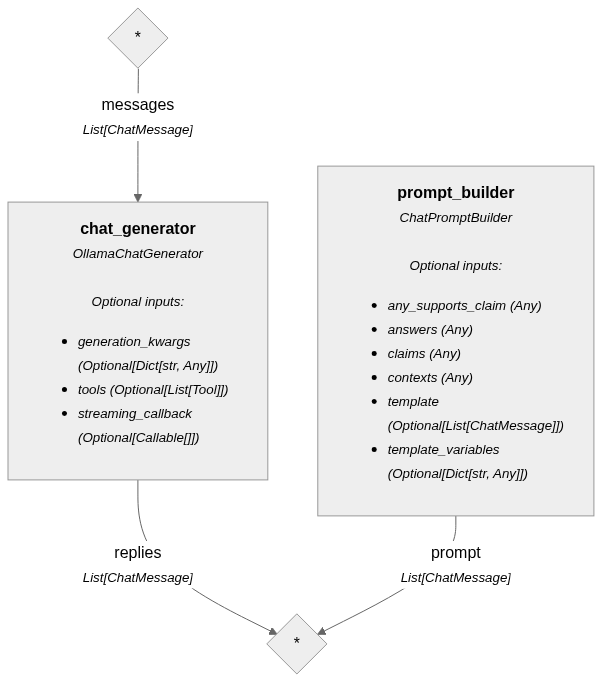

DEBUG - haystack.core.pipeline.base -  Connecting 'prompt_builder.prompt' to 'chat_generator.messages'
DEBUG - haystack.core.pipeline.draw -  Mermaid diagram:

%%{ init: {"theme": "neutral"} }%%

graph TD;

prompt_builder["<b>prompt_builder</b><br><small><i>ChatPromptBuilder<br><br>Optional inputs:<ul style='text-align:left;'><li>any_supports_claim (Any)</li><li>answers (Any)</li><li>claims (Any)</li><li>contexts (Any)</li><li>template (Optional[List[ChatMessage]])</li><li>template_variables (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component -- "prompt -> messages<br><small><i>List[ChatMessage]</i></small>" --> chat_generator["<b>chat_generator</b><br><small><i>OllamaChatGenerator<br><br>Optional inputs:<ul style='text-align:left;'><li>generation_kwargs (Optional[Dict[str, Any]])</li><li>tools (Optional[List[Tool]])</li><li>streaming_callback (Optional[Callable[]])</li></ul></i></small>"]:::component
chat_generator["<b>chat_generator</b><br><small><i>OllamaChatGenerator<br>

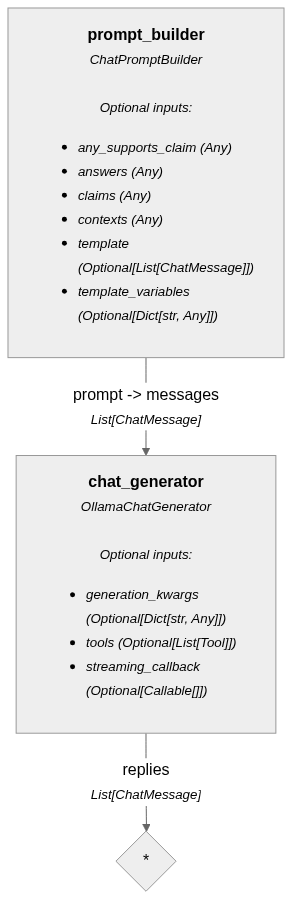

INFO - haystack.core.pipeline.pipeline -  Running component prompt_builder
INFO - haystack.core.pipeline.pipeline -  Running component chat_generator


In [62]:
from print.with_color import print_wc
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack_integrations.components.generators.ollama import OllamaChatGenerator
from haystack.dataclasses import ChatMessage


ollama = OllamaChatGenerator(model="mistral:latest",
                            url = "http://localhost:11434",
                            )
user = """
Given the claim:
'''{{claims}}'''
for the context:
'''{{contexts}}'''

And the following extracted snippets from documents:

{% for answer in answers %}
---
**Snippet {{ loop.index }}**:
{{ answer.data }}

**Document Title**: {{ answer.document.meta.title or "Unknown Title" }}
**URL**: {{ answer.document.meta.get('url') }}
{% endfor %}

Determine which (if any) of the above snippets contain factual evidence that directly supports the claim. Your response must follow this JSON format:

{
  "claim_valid": {{ "true" if any_supports_claim else "false" }},
  "citations": [
    {% for answer in answers  %}
    {
      "title": "{{ answer.document.meta.title or '' }}",
      "url": "{{ answer.document.meta.get('url') }}",
      "snippet": "{{ answer.data | replace('\n', ' ') | replace('\"', '\\\"') }}"
    }{% if not loop.last %},{% endif %}
    {% endfor %}
  ]
}

Only include snippets that factually support the claim. If none support it, set `"claim_valid": false` and leave `"citations"` as an empty list.
"""
system = '''
You are a fact-checking assistant.
Your response must follow JSON format suggested by user.
'''

template = [
    ChatMessage.from_system(system),
    ChatMessage.from_user(user)
]

prompt_builder = ChatPromptBuilder(template=template)
# messages = prompt.run(claim=claim, context= context, answers=answers)

augment_pipeline = Pipeline()
augment_pipeline.add_component('chat_generator', ollama)
augment_pipeline.add_component('prompt_builder', prompt_builder)
augment_pipeline.show()

augment_pipeline.connect('prompt_builder.prompt', 'chat_generator.messages')
augment_pipeline.show()
answers = [extracted['reader']['answers'][0], extracted['reader']['answers'][1], extracted['reader']['answers'][2]]

augmented = augment_pipeline.run({'prompt_builder': {'claims': claim, 'contexts': context, 'answers': answers}})

In [73]:
to_edit = str(augmented['chat_generator']['replies'][-1].text)
print_wc(to_edit)

' {\n      "claim_valid": false,\n      "citations": [\n        {\n          "title": "",\n          "url": 
"https://thebetterindia.com/129195/republic-day-history/",\n          "snippet": "It was only after the Constitution of India came
into effect on 26th January 1950"\n        },\n        {\n          "title": "",\n          "url": 
"https://thebetterindia.com/129195/republic-day-history/",\n          "snippet": "why did it wait for over two and a half years"\n
}\n      ]\n    }'

' {\n      "claim_valid": false,\n      "citations": [\n        {\n          "title": "",\n          "url": 
"https://thebetterindia.com/129195/republic-day-history/",\n          "snippet": "It was only after the 
Constitution of India came into effect on 26th January 1950"\n        },\n        {\n          "title": "",\n      
"url": "https://thebetterindia.com/129195/republic-day-history/",\n          "snippet": "why did it wait for over 
two and a half years"\n        }\n      ]\n    }'

In [77]:
def clean_and_parse_dict(text: str) -> dict:
    """
    Clean a string representation of a dictionary by removing extra newlines and spaces,
    then parse it back into a dictionary.
    
    Args:
        text (str): The string representation of a dictionary
        
    Returns:
        dict: The cleaned and parsed dictionary
    """
    import json
    import re
    
    # Remove leading/trailing whitespace and quotes
    text = text.strip().strip("'")
    
    # Remove extra newlines and spaces while preserving the structure
    text = re.sub(r'\n\s+', ' ', text)  # Replace newlines followed by spaces with a single space
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    
    try:
        # Parse as JSON
        return json.loads(text)
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {str(e)}")
        print("Attempting to fix and parse again...")
        # If parsing fails, try to fix common issues
        text = text.replace("'", '"')  # Replace single quotes with double quotes
        return json.loads(text)

# Clean and parse the dictionary
cleaned_dict = clean_and_parse_dict(to_edit)
print("Cleaned Dictionary:")
print_wc(cleaned_dict)

Cleaned Dictionary:


{
    'claim_valid': False,
    'citations': [
        {
            'title': '',
            'url': 'https://thebetterindia.com/129195/republic-day-history/',
            'snippet': 'It was only after the Constitution of India came into effect on 26th January 1950'
        },
        {
            'title': '',
            'url': 'https://thebetterindia.com/129195/republic-day-history/',
            'snippet': 'why did it wait for over two and a half years'
        }
    ]
}

{
    'claim_valid': False,
    'citations': [
        {
            'title': '',
            'url': 'https://thebetterindia.com/129195/republic-day-history/',
            'snippet': 'It was only after the Constitution of India came into effect on 26th January 1950'
        },
        {
            'title': '',
            'url': 'https://thebetterindia.com/129195/republic-day-history/',
            'snippet': 'why did it wait for over two and a half years'
        }
    ]
}